In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from tensorflow.keras import layers
import time
import datetime

from IPython import display


Let's grab a sample image to see how imread/imshow work

In [2]:
sample_image=plt.imread('images/0c5cca729feb2ca2474e8476653186fb08b26277.png')

[[[0.07843138 0.07450981 0.09411765]
  [0.07843138 0.07450981 0.09411765]
  [0.08627451 0.08235294 0.10196079]
  ...
  [0.02745098 0.02745098 0.02745098]
  [0.03137255 0.03137255 0.03137255]
  [0.03529412 0.03529412 0.03529412]]

 [[0.08627451 0.08235294 0.10196079]
  [0.09411765 0.09019608 0.10980392]
  [0.15686275 0.15294118 0.17254902]
  ...
  [0.03137255 0.03137255 0.03137255]
  [0.02745098 0.02745098 0.02745098]
  [0.02745098 0.02745098 0.02745098]]

 [[0.07450981 0.07058824 0.09019608]
  [0.08627451 0.08235294 0.10196079]
  [0.15294118 0.14901961 0.16862746]
  ...
  [0.03921569 0.03921569 0.03921569]
  [0.03137255 0.03137255 0.03137255]
  [0.02745098 0.02745098 0.02745098]]

 ...

 [[0.20784314 0.1254902  0.10588235]
  [0.20784314 0.1254902  0.10588235]
  [0.21176471 0.12941177 0.10980392]
  ...
  [0.22745098 0.13725491 0.11372549]
  [0.22745098 0.13725491 0.11372549]
  [0.22745098 0.13725491 0.11372549]]

 [[0.20784314 0.1254902  0.10588235]
  [0.20784314 0.1254902  0.10588235]


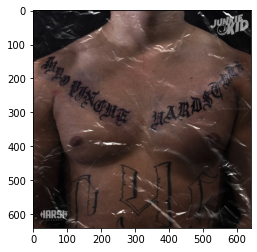

In [3]:
plt.imshow(sample_image)
print(sample_image)
print(sample_image.shape)

OK, now we can glob the filenames from the images folder and make a list comprehension of all the images. Better make them numpy arrays.

In [4]:
train_features = pd.read_csv("track_db.csv")
print(train_features.head)
train_features['id']=train_features['image_url'].map(lambda x:x[24:] if type(x)==str else x)

train_features = train_features.dropna(axis=0)
train_features = train_features.drop_duplicates(subset='id', ignore_index=True)
print(len(train_features))
print(train_features.head)

labels = [(x[7:])[:-4] for x in glob.glob("images/*.png")]
labels.sort()

has_image_mask = train_features['id'].apply(lambda x:x in labels)
print(has_image_mask)
train_features = train_features.loc[has_image_mask]



train_numerical_features = train_features.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'track_name', 'artist_name', 'image_url'])
train_numerical_features_sorted = train_numerical_features.sort_values('id',)
print(len(train_numerical_features_sorted))
ids = train_numerical_features_sorted.pop("id")
print(ids)


<bound method NDFrame.head of        Unnamed: 0  Unnamed: 0.1  \
0               0           0.0   
1               1           1.0   
2               2           2.0   
3               3           3.0   
4               4           4.0   
...           ...           ...   
11948       11948         455.0   
11949       11949         456.0   
11950       11950         457.0   
11951       11951         458.0   
11952       11952         459.0   

                                          Unnamed: 0.1.1  \
0                                                    0.0   
1                                                    1.0   
2                                                    2.0   
3                                                    3.0   
4                                                    4.0   
...                                                  ...   
11948                          Broadway (Manhattan Mary)   
11949  What Wouldn't I Do for that Man (from "Glorify...   
11950    

In [5]:
labels = [(x[7:])[:-4] for x in glob.glob("images/*.png")]
labels.sort()
print(len(labels))
missing_ids = []
for l in labels:
    if l not in ids.to_numpy():
        #print(l)
        missing_ids.append(l)
        os.remove(f"images/{l}.png")
print(len(missing_ids))


6983
0


In [6]:
IMG_W=640
IMG_H=640
BATCH_SIZE=8



numerical_features_ds = tf.data.Dataset.from_tensor_slices(train_numerical_features_sorted.to_numpy()).batch(BATCH_SIZE)

print(tf.data.experimental.cardinality(numerical_features_ds))



train_images_ds = tf.keras.preprocessing.image_dataset_from_directory('images/',labels=None, seed=42, image_size=(IMG_H, IMG_W), batch_size=BATCH_SIZE)

print(tf.data.experimental.cardinality(train_images_ds))

train_images_numerical_features_ds = tf.data.Dataset.zip((numerical_features_ds, train_images_ds)).prefetch(tf.data.AUTOTUNE)
print(tf.data.experimental.cardinality(train_images_numerical_features_ds))



tf.Tensor(873, shape=(), dtype=int64)
Found 6983 files belonging to 1 classes.
tf.Tensor(873, shape=(), dtype=int64)
tf.Tensor(873, shape=(), dtype=int64)


In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(20*20*256, use_bias=False, input_shape=(100,))) # Flat NN take 100-d vector to 20*20*1536=614,400-d vector. 
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((20, 20, 256))) # Here we prepare the data for our Conv2D, we 'generated' a 20x20 image with 1536 pixel features/filters--Maybe fuzzy stamps is a good way to think about it.and
    assert model.output_shape == (None, 20, 20, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 20, 20, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 40, 40, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 80, 80, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 160, 160, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(8, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 320, 320, 8)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 640, 640, 3)

    return model

In [8]:
generator = make_generator_model()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


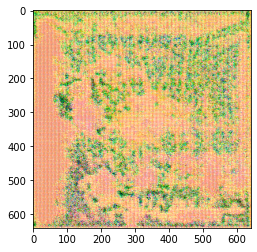

In [23]:

noise = tf.random.normal([1, 90])
label = tf.random.normal([1, 10])
input = tf.concat([label, noise], axis=1)

generated_image = generator(input, training=False)


plt.imshow(generated_image[0, :, :, :])

In [10]:
def make_discriminator_model():
    model=tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2,2), padding='same', input_shape=[640, 640, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1)) # I only care about fooling the discriminator

    return model


In [11]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-9.8217504e-05]], shape=(1, 1), dtype=float32)


In [12]:
cross_entropy_veracity = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [13]:
def discriminator_loss(real_output, fake_output):
    assert real_output.shape[1] == 1 and fake_output.shape[1] == 1
    real_loss = cross_entropy_veracity(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy_veracity(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss 
    return total_loss

In [14]:
def generator_loss(fake_output):
    fake_loss = cross_entropy_veracity(tf.ones_like(fake_output), fake_output)
    return fake_loss 

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer
                                , discriminator_optimizer=discriminator_optimizer
                                , generator=generator
                                , discriminator=discriminator)

In [17]:
EPOCHS = 20
noise_dim = 90
num_examples_to_generate = 3

seed = tf.random.normal([num_examples_to_generate, noise_dim])
sample_labels = tf.random.normal([num_examples_to_generate, 100-noise_dim])

gen_loss_func = tf.keras.metrics.BinaryCrossentropy('gen_loss', dtype=tf.float32)
disc_loss_func = tf.keras.metrics.BinaryCrossentropy('disc_loss', dtype=tf.float32)




In [18]:
#@tf.function
def train_step(images, labels):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    random_labels = tf.random.normal([BATCH_SIZE, 10])
    input = tf.concat([random_labels, noise], axis=1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(input, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)


        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    

In [19]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
gen_log_dir = 'logs/gradient_tape/' + current_time + '/gen'
disc_log_dir = 'logs/gradient_tape/' + current_time + '/disc'
gen_summary_writer = tf.summary.create_file_writer(gen_log_dir)
disc_summary_writer = tf.summary.create_file_writer(disc_log_dir)

In [20]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(5,4))

    for i in range(predictions.shape[0]):
        plt.subplot(1, 3, i+1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')

    plt.savefig(f"image_at_epoch_{epoch}.png", dpi=200)
    plt.show()

In [25]:
def train(dataset, epochs, offset=0):
    for epoch in range(epochs):
        start = time.time()

        for feature_batch, image_batch in dataset:
            train_step(image_batch, feature_batch)

        with gen_summary_writer.as_default():
            tf.summary.scalar('gen_loss', gen_loss_func.result(), step=epoch+offset)
        with disc_summary_writer.as_default():   
            tf.summary.scalar('disc_loss', disc_loss_func.result(), step=epoch+offset)

        template = 'Epoch {}, Generator Loss: {}, Discriminator Loss: {}'
        print (template.format(epoch+1+offset,
                                gen_loss_func.result(), 
                                disc_loss_func.result()))
        # Reset metrics every epoch
        gen_loss_func.reset_states()
        disc_loss_func.reset_states()

        generate_and_save_images(generator, epoch+1+offset, tf.concat([sample_labels, seed], axis=1))

        if(epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f'Time for epoch {epoch+1+offset} is {time.time()-start}')

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs+offset, tf.concat([sample_labels, seed], axis=1))

In [26]:
status = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


In [24]:
train(train_images_numerical_features_ds, EPOCHS, 90)

NameError: name 'gen_loss' is not defined

In [32]:
anim_file='coverartgan.gif'

with imageio.get_writer(anim_file, mode="I") as writer:
    filenames = glob.glob('image*.png')
    filenumber = [int(name[15:-4]) for name in filenames]
    filenames = zip(filenames, filenumber)
    filenames = sorted(filenames, key = lambda x:x[1])

    for filename, num in filenames:
        print(num)
        image = imageio.imread(filename)
        writer.append_data(image)

    image = imageio.imread(filename)
    writer.append_data(image)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90



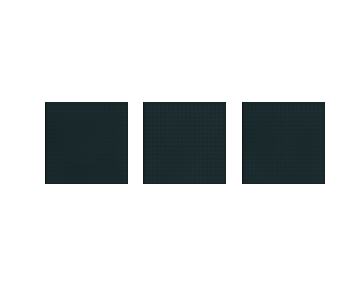

In [33]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)